# Lab 3 - Homography

In [1]:
#import cv2
import numpy as np
from cv2 import imread, imwrite, cvtColor, resize
from cv2 import COLOR_BGR2GRAY, COLOR_BGR2RGB
from cv2 import SIFT_create, BFMatcher, norm 
from cv2 import warpPerspective

from tqdm import tqdm
from time import time
from numba import njit

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generateRandom(src_Pts, dest_Pts, N):
    # Randomly selects N coresponding points
    
    r = np.random.choice(len(src_Pts), N)
    src = [src_Pts[i] for i in r]
    dest = [dest_Pts[i] for i in r]
    return np.asarray(src, dtype=np.float32), np.asarray(dest, dtype=np.float32)


def ransacHomography(src_Pts, dst_Pts):
    
    maxI = 0
    maxLSrc = []
    maxLDest = []
    
    for i in range(70):
        srcP, destP = generateRandom(src_Pts, dst_Pts, 4)
        H = find_H(srcP, destP, 4)
        inlines = 0
        linesSrc = []
        lineDest = []
        for p1, p2 in zip(src_Pts, dst_Pts):
            p1U = (np.append(p1, 1)).reshape(3, 1)
            p2e = H.dot(p1U)
            p2e = (p2e / p2e[2])[:2].reshape(1, 2)[0]
            if norm(p2 - p2e) < 10:
                inlines += 1
                linesSrc.append(p1)
                lineDest.append(p2)
        if inlines > maxI:
            maxI = inlines
            maxLSrc = linesSrc.copy()
            maxLSrc = np.asarray(maxLSrc, dtype=np.float32)
            maxLDest = lineDest.copy()
            maxLDest = np.asarray(maxLDest, dtype=np.float32)
    Hf = find_H(maxLSrc, maxLDest, maxI)
    return Hf


def find_H(src, dest, N):
    
    A = []
    for i in range(N):
        x, y = src[i][0], src[i][1]
        xp, yp = dest[i][0], dest[i][1]
        A.append([x, y, 1, 0, 0, 0, -x * xp, -xp * y, -xp])
        A.append([0, 0, 0, x, y, 1, -yp * x, -yp * y, -yp])
        
    A = np.asarray(A)
    U, S, Vh = np.linalg.svd(A)
    L = Vh[-1, :] / Vh[-1, -1]
    H = L.reshape(3, 3)
    return H

In [3]:
def get_H(img1, img2):
    '''
    img1 - center
    img2 - panned
    '''
    
    # detect kepoints and their descriptor for 'img1' using SIFT
    sift = SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Keypoints matching
    bf = BFMatcher() 
    matches = bf.knnMatch(des1,des2, k=2)
    good = []

    for m in matches:
        if (m[0].distance < 0.5*m[1].distance):
            good.append(m)
    matches = np.asarray(good)

    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    
    
    # Matrix
    H = ransacHomography(src[:200, 0, :], dst[:200, 0, :])
    
    return H

In [4]:
@njit
def reconstruction(img2_clr, H, y_max, y_min, x_max, x_min ):

    img2_warped = np.zeros( (y_max - y_min, x_max - x_min, 3) ) 

    for y in range(0 + y_min, img2_warped.shape[0]):
        for x in range(0 + x_min, img2_warped.shape[1]):
            
            p_src = np.array([x, y, 1], dtype = np.float64)
            p_dst = H.dot(p_src)
            p_dst[0] = p_dst[0]/p_dst[2]
            p_dst[1] = p_dst[1]/p_dst[2]
            p_dst[2] = p_dst[2]/p_dst[2]

            x_new = int(p_dst[0])
            y_new = int(p_dst[1])

            if 0 < y_new < img1.shape[0]-1 and 0 < x_new < img1.shape[1]-1:
                img2_warped[y - y_min, x - x_min] = ( (x_new - int(x_new))*(y_new - int(y_new))*img2_clr[int(y_new+1), int(x_new+1)] 

                                                        +(int(x_new+1) - x_new)*(y_new - int(y_new))*img2_clr[int(y_new+1), int(x_new)]

                                                        +(x_new - int(x_new))*(int(y_new+1) - y_new)*img2_clr[int(y_new), int(x_new+1)]

                                                        +(int(x_new+1) - x_new)*(int(y_new+1) - y_new)*img2_clr[int(y_new), int(x_new)] )
                    
                    
    return img2_warped

In [5]:
def warped_points(Hinv, s):
    t = [0,0,0,0]
    t[0] = np.dot(Hinv, s[0])
    t[1] = np.dot(Hinv, s[1])
    t[2] = np.dot(Hinv, s[2])
    t[3] = np.dot(Hinv, s[3])
    
    t[0] = t[0]/t[0][2]
    t[1] = t[1]/t[1][2]
    t[2] = t[2]/t[2][2]
    t[3] = t[3]/t[3][2]
    
    return t

---

## Imgs import

In [6]:
img1_clr = imread("imgs/s4a.jpg")
img2_clr = imread("imgs/s4b.jpg")
img3_clr = imread("imgs/s4c.jpg")

img1 = cvtColor(img1_clr, COLOR_BGR2GRAY)
img2 = cvtColor(img2_clr, COLOR_BGR2GRAY)
img3 = cvtColor(img3_clr, COLOR_BGR2GRAY)

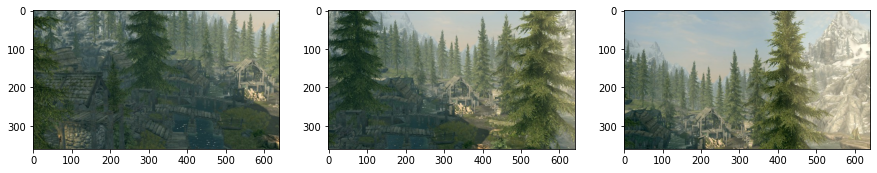

In [7]:
fig = plt.figure(figsize=(15, 12)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 3) 
plt.imshow(cvtColor(img3_clr, COLOR_BGR2RGB)) 

---

## Left part H

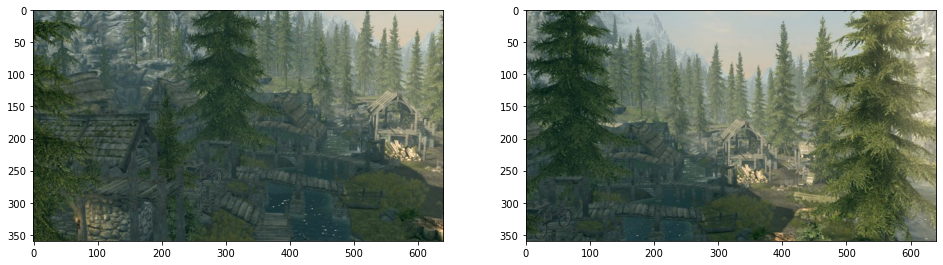

In [8]:
fig = plt.figure(figsize=(25, 15)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2_clr, COLOR_BGR2RGB)) 

In [9]:
H_l = get_H(img2, img1)
Hinv_l = np.linalg.inv(H_l)

---

## Right part H

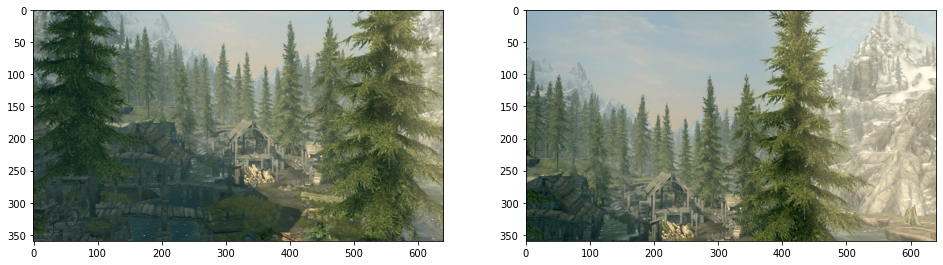

In [10]:
fig = plt.figure(figsize=(25, 15)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img2_clr, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img3_clr, COLOR_BGR2RGB)) 

In [11]:
H_r = get_H(img2, img3)
Hinv_r = np.linalg.inv(H_r)
H_l, Hinv_l

(array([[ 6.44209885e-01,  2.98572024e-02,  2.40122754e+02],
        [-6.50291524e-02,  9.22797574e-01, -3.16954846e+01],
        [-6.00504689e-04,  1.42244701e-04,  1.00000000e+00]]),
 array([[ 1.26901136e+00,  5.88313116e-03, -3.04532033e+02],
        [ 1.15038812e-01,  1.07892589e+00,  6.57364280e+00],
        [ 7.45683609e-04, -1.49938644e-04,  8.16192020e-01]]))

---

## Create base

In [12]:
# source       x  y  1
s = [0,0,0,0]
s[0] = np.array([0, 0, 1])
s[1] = np.array([img2.shape[1], 0, 1])
s[2] = np.array([0, img2.shape[0], 1])
s[3] = np.array([img2.shape[1], img2.shape[0], 1])

In [13]:
x = np.zeros((12), dtype=np.int32)
y = np.zeros((12), dtype=np.int32)

x[0:4] = s[0][0], s[1][0], s[2][0], s[3][0]
y[0:4] = s[0][1], s[1][1], s[2][1], s[3][1]

left_p = warped_points(Hinv_l, s)
right_p = warped_points(Hinv_r, s)

x[4:8] = left_p[0][0], left_p[1][0], left_p[2][0], left_p[3][0]
x[8:12] = right_p[0][0], right_p[1][0], right_p[2][0], right_p[3][0]

y[4:8] = left_p[0][1], left_p[1][1], left_p[2][1], left_p[3][1]
y[8:12] = right_p[0][1], right_p[1][1], right_p[2][1], right_p[3][1]

x = sorted(x)
y = sorted(y)

In [14]:
x, y

([-396, -373, 0, 0, 123, 145, 392, 411, 640, 640, 798, 845],
 [-137, -71, 0, 0, 8, 62, 263, 293, 360, 360, 378, 518])

In [15]:
x_min, x_max = x[0], x[-1]
y_min, y_max = y[0], y[-1]

---

### Warping

In [16]:
start = time()
img1_warped = ( reconstruction(img1_clr, H_l, y_max, y_min, x_max, x_min ) ).astype(np.uint8)
print('Time: ', time() - start)

Time:  1.1501400470733643


In [17]:
start = time()
img2_warped = ( reconstruction(img2_clr, np.identity(3), y_max, y_min, x_max, x_min ) ).astype(np.uint8)
print('Time: ', time() - start)

Time:  0.3253142833709717


In [18]:
start = time()
img3_warped = ( reconstruction(img3_clr, H_r, y_max, y_min, x_max, x_min ) ).astype(np.uint8)
print('Time: ', time() - start)

Time:  0.32637548446655273


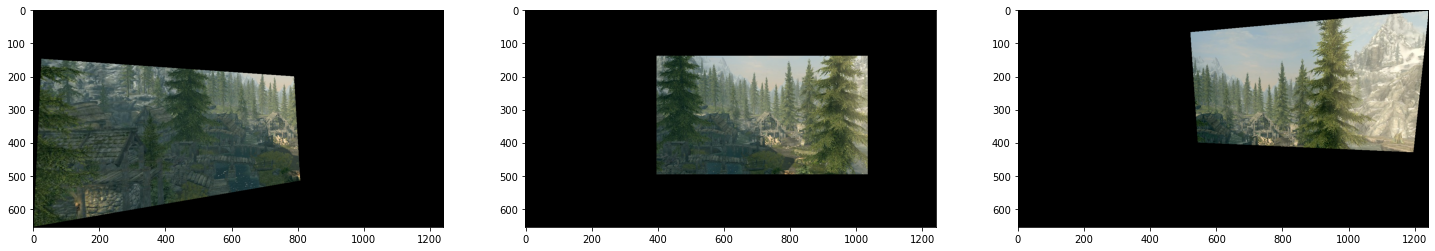

In [19]:
fig = plt.figure(figsize=(25, 15)) 
fig.add_subplot(1, 3, 1) 
plt.imshow(cvtColor(img1_warped, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 2) 
plt.imshow(cvtColor(img2_warped, COLOR_BGR2RGB)) 
fig.add_subplot(1, 3, 3) 
plt.imshow(cvtColor(img3_warped, COLOR_BGR2RGB)) 

In [20]:
plt.imsave('1.png', cvtColor(img1_warped, COLOR_BGR2RGB))
plt.imsave('2.png', cvtColor(img2_warped, COLOR_BGR2RGB))
plt.imsave('3.png', cvtColor(img3_warped, COLOR_BGR2RGB))

---

## Check result

In [21]:
res = np.zeros_like(img2_warped, dtype=np.uint8)
zero = np.zeros(3, dtype=np.uint8)

for y in range(img2_warped.shape[0]):
    for x in range(img2_warped.shape[1]):
        
        if (img2_warped[y,x,:] == zero).all():
            res[y,x] += img1_warped[y,x] + img3_warped[y,x]
        else:
            res[y,x] += img2_warped[y,x]

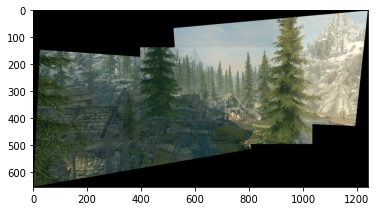

In [23]:
plt.imshow(cvtColor(res, COLOR_BGR2RGB))
plt.imsave('temp_res.png', cvtColor(res, COLOR_BGR2RGB))